In [1]:
import nibabel as nib
import scipy.linalg as la
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nilearn.plotting

In [24]:
subject = 'sub-sid000021'

In [25]:
func_fns = sorted(glob(f'/home/vassiki/budapest_data/outputs/fmriprep/{subject}/func/*space-T1w_desc-preproc_bold.nii.gz'))
conf_fns = sorted(glob(f'/home/vassiki/budapest_data/outputs/fmriprep/{subject}/func/*tsv'))

In [26]:
from numpy.polynomial.legendre import Legendre
import numpy as np

In [48]:
def compute_tsnr(data, conf):
    # reshape
    data = data.T
    orig_shape = data.shape
    data = data.reshape(orig_shape[0], -1)
    data_mean = data.mean(0)
    # make predictor matrix
    # first add polynomial regressors -- code lifted from nipype
    poly_degree = 1
    n_samples = data.shape[0]
    X = np.ones((n_samples, 1))  # mean
    for d in range(poly_degree):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    # then add compcor confounds and additional noise regressors
    confounds = [
        'framewise_displacement'
    ]
    n_comp_cor = 10
    confounds += [f"a_comp_cor_{c:02d}" for c in range(n_comp_cor)]
    X = np.hstack((X, conf[confounds].values))

    X = np.nan_to_num(X)

    coef, _, _, _ = la.lstsq(X, data)
    data_clean = data - X.dot(coef)

    std = data_clean.std(0)
    std[std < 1e-8] = 1
    tsnr = data_mean / std
    # reshape to the original shape
    tsnr = tsnr.reshape(orig_shape[1:]).T
    return tsnr

In [49]:
tsnr_runs = []
for f, c in zip(func_fns, conf_fns):
    print(f.split('/')[-1])
    data = nib.load(f).get_fdata()

    
    conf = pd.read_csv(c, sep='\t')
    tsnr_runs.append(compute_tsnr(data, conf))

sub-sid000021_task-movie_run-01_space-T1w_desc-preproc_bold.nii.gz
sub-sid000021_task-movie_run-02_space-T1w_desc-preproc_bold.nii.gz
sub-sid000021_task-movie_run-03_space-T1w_desc-preproc_bold.nii.gz
sub-sid000021_task-movie_run-04_space-T1w_desc-preproc_bold.nii.gz
sub-sid000021_task-movie_run-05_space-T1w_desc-preproc_bold.nii.gz


In [50]:
[t.shape for t in tsnr_runs]

[(62, 72, 58), (62, 72, 58), (62, 72, 58), (62, 72, 58), (62, 72, 58)]

In [51]:
def make_matrix(t):
    # add an extra slice top and bottom
    dim1, dim2, dim3 = t.shape
    empty_slice = np.zeros((dim1, dim2, 1))
    t = np.concatenate((empty_slice, t, empty_slice), -1)
    # split into 6 rows
    t = np.split(t, 6, -1)
    # make matrix
    t = np.vstack([tt.transpose(1, 0, 2).reshape(dim2, -1, order='F') for tt in t])
    # change order so that plots match standard mosaic order
    t = t[::-1, ::-1]
    return t

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_matrix(mat, vmin=30, vmax=250, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(18, 18))
    im = ax.matshow(mat, vmin=vmin, vmax=vmax, interpolation='nearest', cmap='inferno')
    if title:
        ax.text(0, 0, title, ha='left', va='top', fontsize=24, bbox=dict(facecolor='white', alpha=1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis('off')
    return fig

In [53]:
mat_runs = [make_matrix(t) for t in tsnr_runs]

In [54]:
# compute median tsnr
median_mat_run = make_matrix(np.median(tsnr_runs, 0))

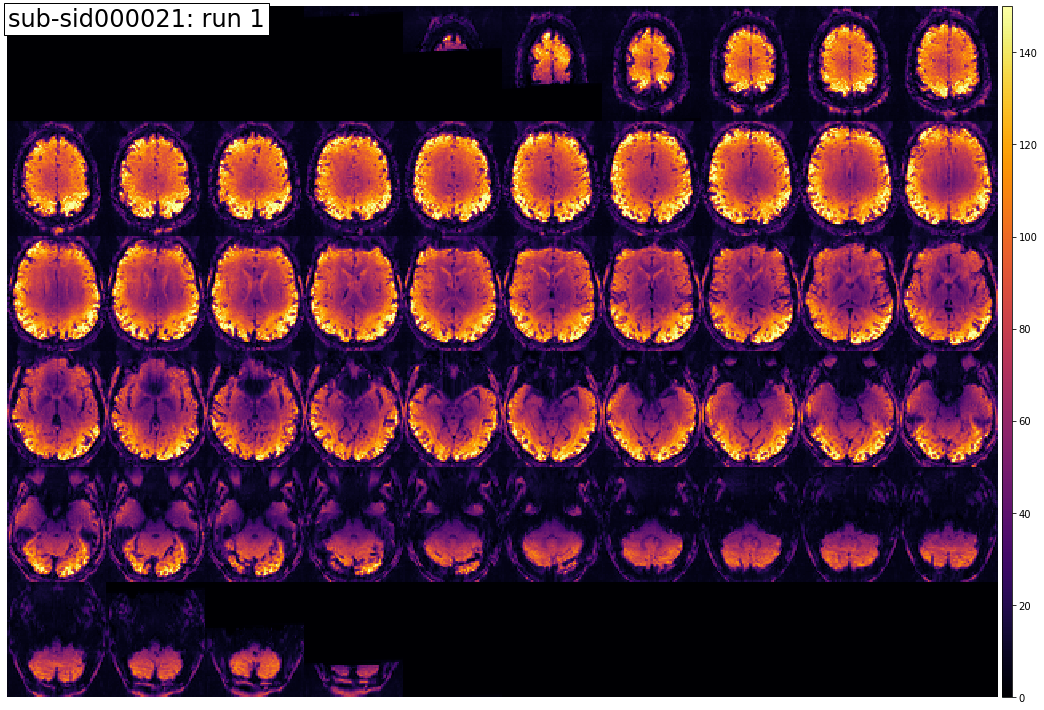

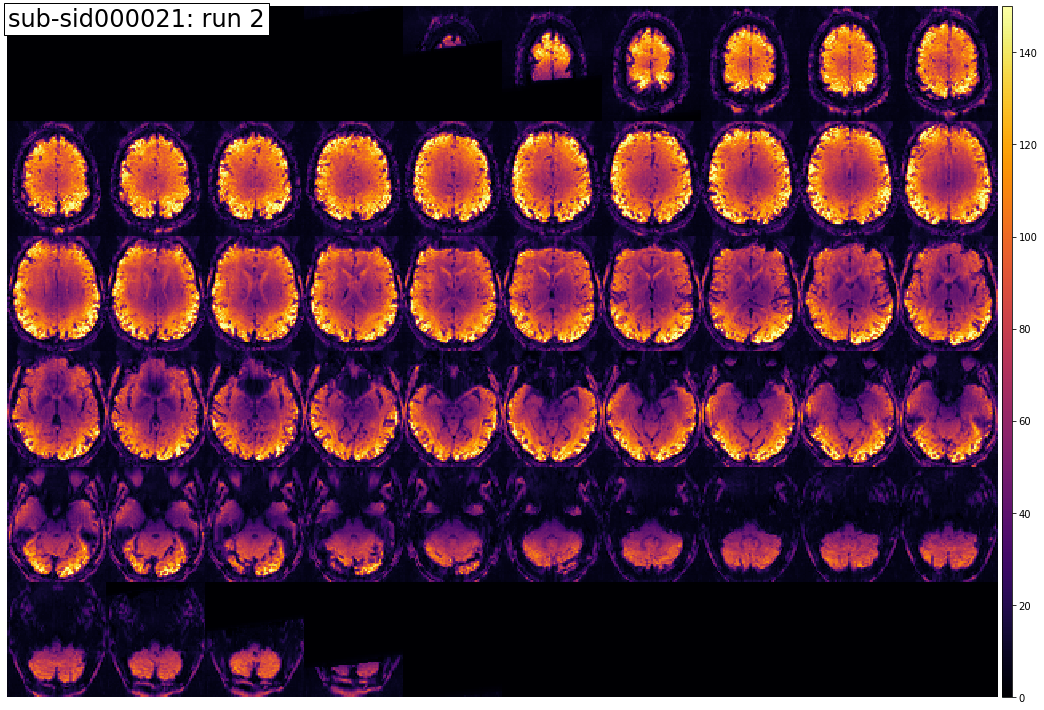

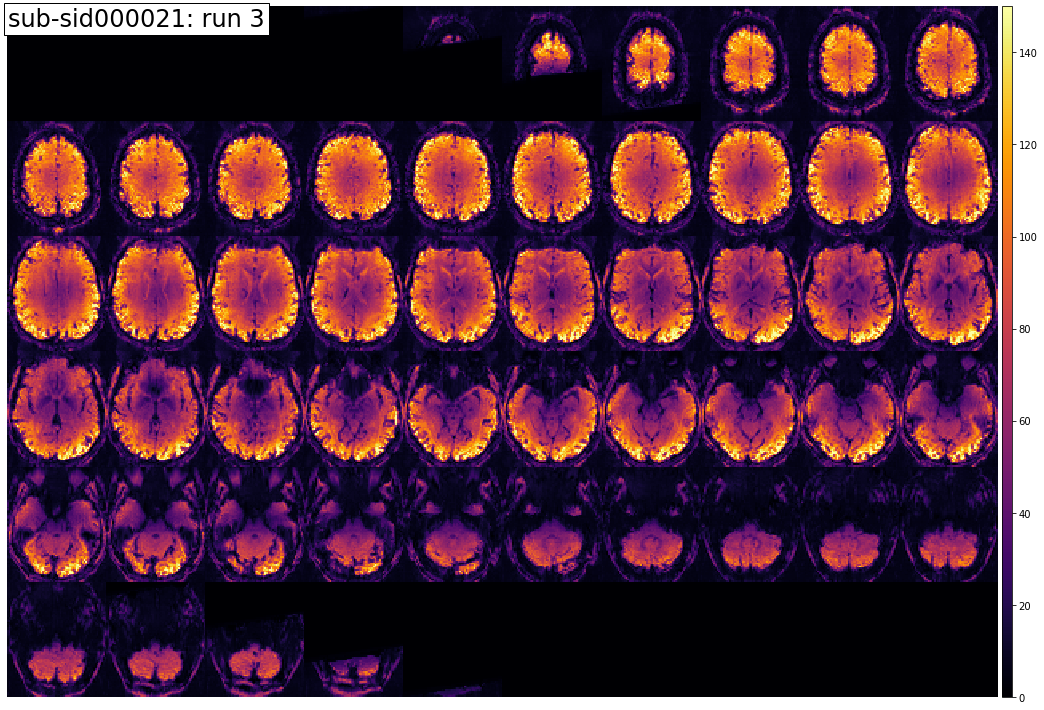

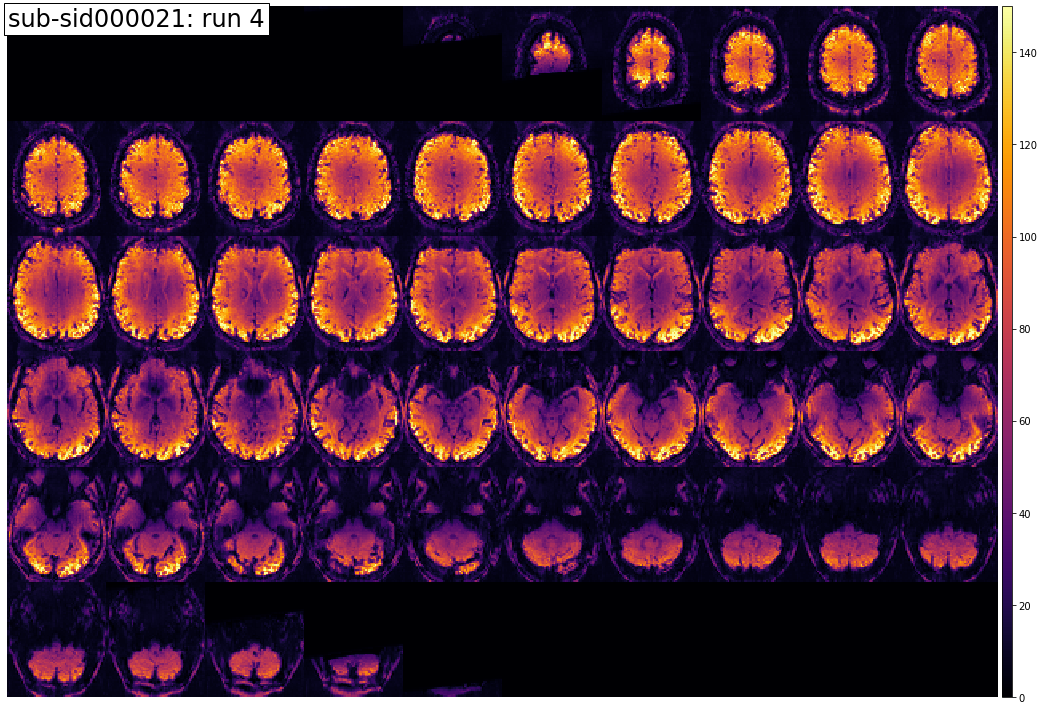

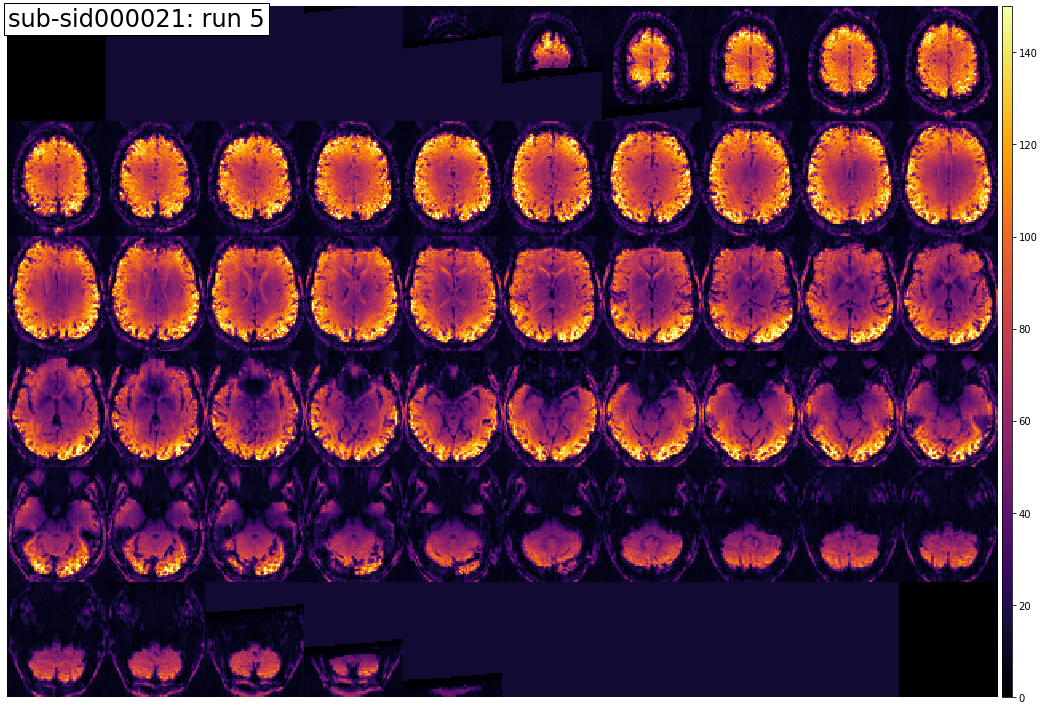

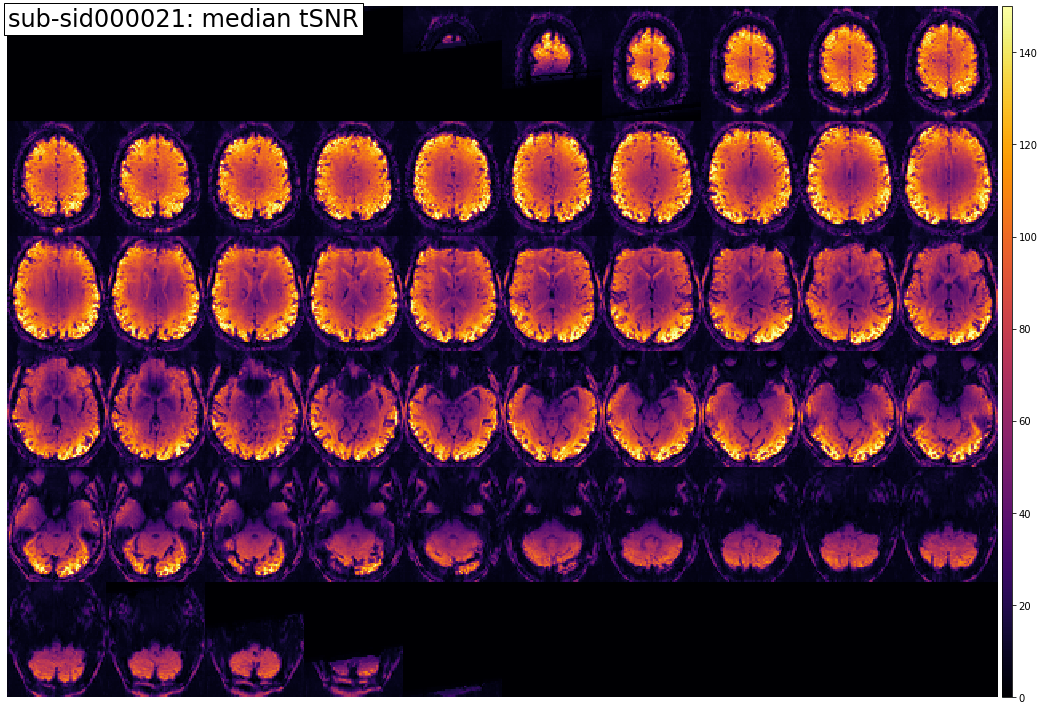

In [55]:
for i, mat in enumerate(mat_runs, 1):
    plot_matrix(mat, vmin=0, vmax=150, title=f'{subject}: run {i}');
plot_matrix(median_mat_run, vmin=0, vmax=150, title=f'{subject}: median tSNR');

In [56]:
mask_fns = sorted(glob(f'/home/vassiki/budapest_data/outputs/fmriprep/{subject}/func/*space-T1w_desc-brain_mask.nii.gz'))

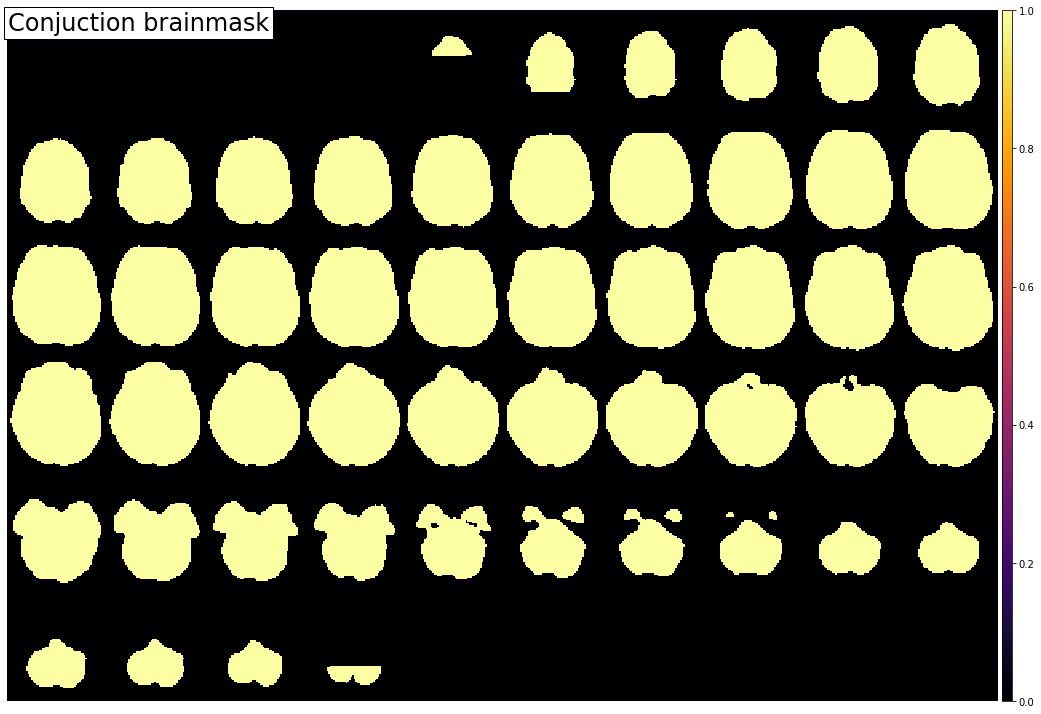

In [57]:
# make a conjuction mask
brainmask = np.ones_like(tsnr_runs[0])
for mask_fn in mask_fns:
    bm = nib.load(mask_fns[0]).get_fdata()
    brainmask *= bm
# plot it
mat_brainmask = make_matrix(brainmask)
plot_matrix(mat_brainmask, vmin=0, vmax=1, title='Conjuction brainmask');

In [58]:
tsnr_runs_masked = [t[brainmask.astype(bool)] for t in tsnr_runs]

In [59]:
tsnr_median_masked = np.median(tsnr_runs_masked, 0)

In [60]:
tsnr_runs_masked.append(tsnr_median_masked)

In [61]:
import seaborn as sns

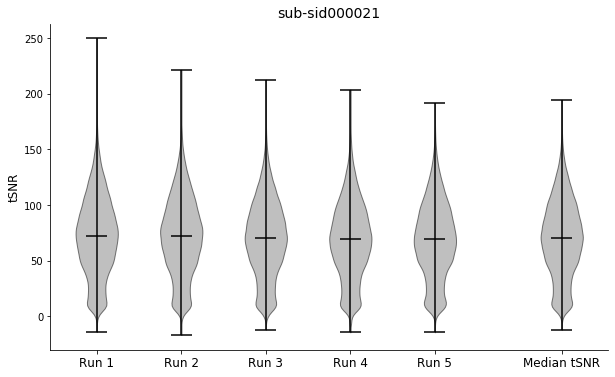

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
pos =[0, 1, 2, 3, 4, 5.5]
parts = ax.violinplot(tsnr_runs_masked, positions=pos, showmedians=True);
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

for p in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    parts[p].set_edgecolor('black')

ax.set_xticks(pos)
ax.set_xticklabels([f"Run {i}" for i in range(1, 6)] + ['Median tSNR'], fontsize=12)
ax.set_ylabel('tSNR', fontsize=12)
ax.set_title(subject, fontsize=14)
sns.despine()

In [63]:
func_fns

['/home/vassiki/budapest_data/outputs/fmriprep/sub-sid000021/func/sub-sid000021_task-movie_run-01_space-T1w_desc-preproc_bold.nii.gz',
 '/home/vassiki/budapest_data/outputs/fmriprep/sub-sid000021/func/sub-sid000021_task-movie_run-02_space-T1w_desc-preproc_bold.nii.gz',
 '/home/vassiki/budapest_data/outputs/fmriprep/sub-sid000021/func/sub-sid000021_task-movie_run-03_space-T1w_desc-preproc_bold.nii.gz',
 '/home/vassiki/budapest_data/outputs/fmriprep/sub-sid000021/func/sub-sid000021_task-movie_run-04_space-T1w_desc-preproc_bold.nii.gz',
 '/home/vassiki/budapest_data/outputs/fmriprep/sub-sid000021/func/sub-sid000021_task-movie_run-05_space-T1w_desc-preproc_bold.nii.gz']